# 시계열 데이터 분석
코랩에서 실행 추천

#### 한글 폰트 설정
- 이 셀 실행 후 [런타임]-[런타임 다시 시작] 실행 

In [2]:
# 한글 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()



Selecting previously unselected package fonts-nanum.
(Reading database ... 160815 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


### 경고 무시

In [3]:
# 경고 무시
import warnings
warnings.filterwarnings(action='ignore')

# 페이스북이 제공하는 Facebook Prophet 라이브러리 이용
- Additive 모델링 방법에 기반한 시계열 예측 모델
> Additive 모델 : 선형 회귀의 단점을 극복하기 위해 계량된 분석 방법의 하나
> 시계열 분석도 회귀 분석의 한 종류이기 때문에 회귀분석의 단점을 가지고 있다.
> 회귀 분석의 단점을 극복하기 위해 각 피처마다 비선형적 적합을 가능하게 하는 일련의 방법을 적용
>참고사이트 : https://peerj.com/preprints/3190/ 
- 시계열 데이타의 트렌드성(연간/월간/일간)을 예측하는 것에 초점이 맞춰진 모델



### 모듈 불러오기

In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

!pip install yfinance

from datetime import datetime

## 시계열 분석으로 주식 데이터 분석하기
#### https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS&.tsrc=fin-srch

### 1) 삼성전자 주식 데이타 불러오기
- pandas_datareader 모듈의 data 클래스 get_data_yahoo() 함수를 이용하여 
- 관심있는 종목의 주가를 특정 기간 추이를 불러온다.


In [5]:
# 삼성전자 코스피 주식 - 코스닥은 `.KQ`, 코스피는 `.KS`가 붙는다.

from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

start_date = '2004-1-1' 
end_date = '2021-07-11'
SAMSUNG = data.get_data_yahoo('005930.KS', start_date, end_date)
    
SAMSUNG.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-05,80100.0,80800.0,80000.0,80400.0,80400.0,8330969
2021-07-06,80600.0,81200.0,80500.0,81200.0,81200.0,12131651
2021-07-07,81200.0,81300.0,80300.0,80800.0,80800.0,15992202
2021-07-08,81100.0,81200.0,79900.0,79900.0,79900.0,16660998
2021-07-09,79600.0,79800.0,79000.0,79400.0,79400.0,22720577


In [6]:
SAMSUNG.shape

(4353, 6)

### 2) 데이타 시각화


In [7]:
SAMSUNG['Close'][-10:]

Date
2021-06-28    81900.0
2021-06-29    81000.0
2021-06-30    80700.0
2021-07-01    80100.0
2021-07-02    80000.0
2021-07-05    80400.0
2021-07-06    81200.0
2021-07-07    80800.0
2021-07-08    79900.0
2021-07-09    79400.0
Name: Close, dtype: float64

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


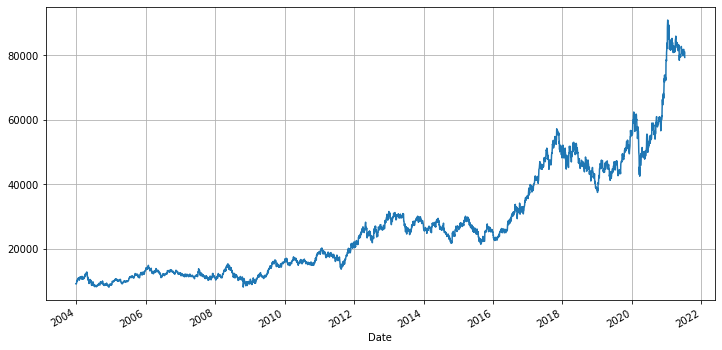

In [8]:
SAMSUNG['Close'].plot(figsize=(12,6), grid=True)

In [9]:
SAMSUNG_trunc = SAMSUNG[:'2021-01-01']
SAMSUNG_trunc.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-23,72400.0,74000.0,72300.0,73900.0,71766.921875,19411326
2020-12-24,74100.0,78800.0,74000.0,77800.0,75554.351562,32502870
2020-12-28,79000.0,80100.0,78200.0,78700.0,76428.375000,40085044
2020-12-29,78800.0,78900.0,77300.0,78300.0,77953.601562,30339449
2020-12-30,77400.0,81300.0,77300.0,81000.0,80641.656250,29417421


# fbprophet 라이브러리 사용 방법
- 1) 대상 데이타프레임 피처를 'ds'와 'y'로 변경
- 2) Prophet 클래스를 선언
> seasonality_mode : 연간, 월간, 주간, 일간 등의 트랜드성을
반영하는 것을 의미하는 파라미터
> changepoint_prior_scale : 트랜드가 변경되는 문맥을 반영하는 파라미터, 수치가 높을 수록 모델은 과적합에 가까워짐
- 3) fit() 함수로 모델을 학습


In [10]:
# Prophet 라이브러리 import 
from fbprophet import Prophet

### 1) 대상 데이타프레임 피처를 'ds'와 'y'로 변경
- 인덱스로 잡혀있는 날짜 데이타를 ds로 변경
- 종가(close)를 y로 변경


In [11]:
import pandas as pd
df = pd.DataFrame({'ds':SAMSUNG_trunc.index, 'y':SAMSUNG_trunc['Close']})

df.reset_index(inplace=True)
df

,Date,ds,y
0,2004-01-01,2004-01-01,9020.0
1,2004-01-02,2004-01-02,8980.0
2,2004-01-05,2004-01-05,9150.0
3,2004-01-06,2004-01-06,9200.0
4,2004-01-07,2004-01-07,9300.0
...,...,...,...
4218,2020-12-23,2020-12-23,73900.0
4219,2020-12-24,2020-12-24,77800.0
4220,2020-12-28,2020-12-28,78700.0
4221,2020-12-29,2020-12-29,78300.0


In [12]:
del df['Date']
df.tail()

,ds,y
4218,2020-12-23,73900.0
4219,2020-12-24,77800.0
4220,2020-12-28,78700.0
4221,2020-12-29,78300.0
4222,2020-12-30,81000.0


### 2) Prophet 클래스를 선언
- seasonality_mode : 연간, 월간, 주간, 일간 등의 트랜드성을
반영하는 것을 의미하는 파라미터
- changepoint_prior_scale : 트랜드가 변경되는 문맥을 반영하는 파라미터, 수치가 높을 수록 모델은 과적합에 가까워짐

In [13]:
prophet = Prophet(seasonality_mode='multiplicative',
                  yearly_seasonality=True,
                  weekly_seasonality=True,
                  daily_seasonality=True,
                  changepoint_prior_scale=0.5)

### 3) fit() 함수로 모델을 학습


In [14]:
prophet.fit(df)

### 4) 300일 후까지의 예측
- make_future_dataframe(periods=300, fred='d')
- prophet.predict(future_data)

In [15]:
future_data = prophet.make_future_dataframe(periods=300)
future_data.tail()

,ds
4518,2021-10-22
4519,2021-10-23
4520,2021-10-24
4521,2021-10-25
4522,2021-10-26


In [16]:
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4518,2021-10-22,58004.594761,52049.080081,63801.210349
4519,2021-10-23,45754.950524,40346.286023,51271.700167
4520,2021-10-24,45833.491608,40772.854618,51620.548072
4521,2021-10-25,58387.531092,52515.246461,64575.801897
4522,2021-10-26,58702.253598,52827.892709,64972.568598


### 5) 예측 데이타 시각화
- seasonality_mode 파라미터를 설정해 놓은 경우에만 시각화 가능
- 시계열 데이타가 어떤 흐름을 가지고 변화하는지를 예측할 수 있음

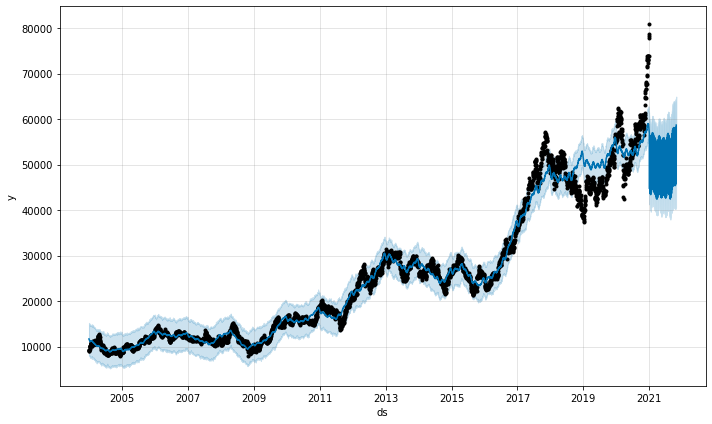

In [17]:
fig1 = prophet.plot(forecast_data)

### 6) year, weekly, daily 순의 트랜드를 확인

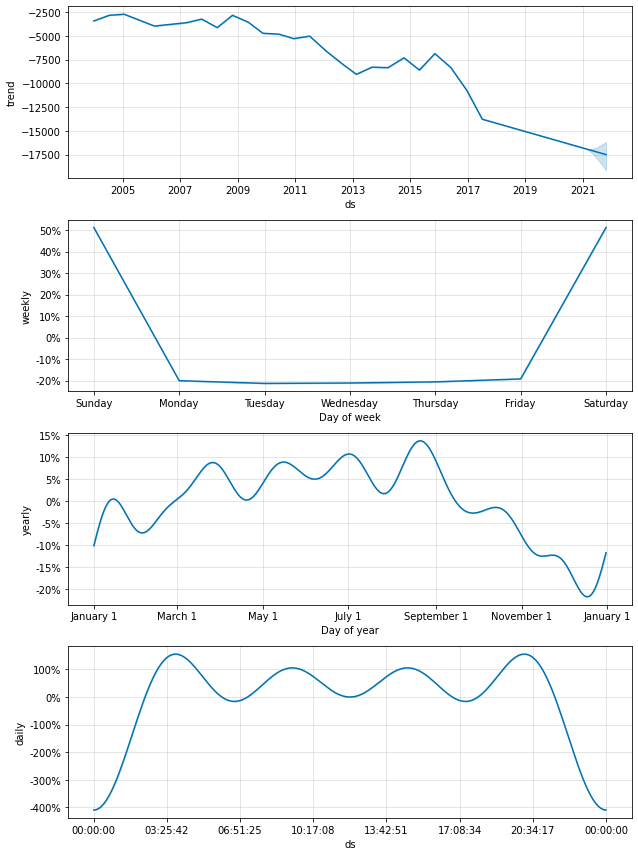

In [18]:
fog2 = prophet.plot_components(forecast_data)

# 시계열 데이타 분석 - 삼성전자 주식 예측 그래프

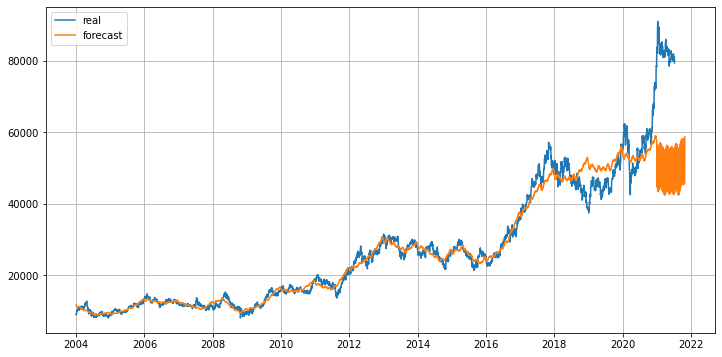

In [19]:
plt.figure(figsize=(12,6))
plt.plot(SAMSUNG.index, SAMSUNG['Close'], label='real')
plt.plot(forecast_data['ds'], forecast_data['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()